In [11]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

In [12]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%autoreload 2

#### Declare Variables 

In [14]:
n_states = 20 #number of states in the GMM
poly_deg = 2 #Degree of the polynomial
n_out = 2 #number of motion variables
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations
t_in = np.linspace(0,1,n_data) #input data for LWR

#### Load Data 

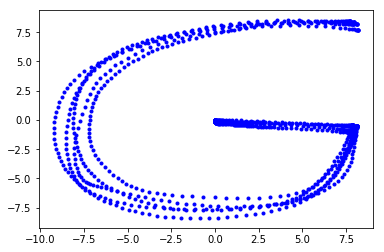

In [15]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

#### Set the basis functions 

In [16]:
t_sep = np.linspace(-0.3,1.3,n_states+1)
mus = np.zeros(n_states)
for i in range(n_states):
    mus[i] = 0.5*(t_sep[i]+t_sep[i+1])

sigmas = np.array([2e-3]*n_states)

In [17]:
from scipy.stats import norm as normal_dist

#### Compute the activation weigths

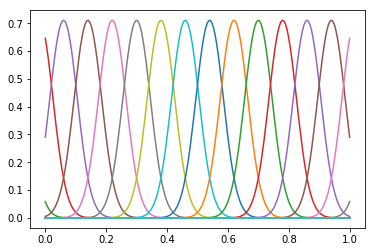

In [19]:
H = np.zeros((n_states, n_data))
for i in range(n_states):
    H[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(t_in)
H /= np.sum(H,axis=0) #normalizing the weights

for i in range(n_states):
    plt.plot(t_in, H[i],'-')

Hn = np.tile(H,(1,n_samples)) #repeat Hn for n samples

#### Compute LWR 

In [20]:
#construct the polynomial input of degree=poly_deg

In [21]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=poly_deg)
Xr = poly.fit_transform(t_in[:,None])
X = np.tile(Xr,(n_samples,1))

In [22]:
from numpy import dot
from numpy.linalg import inv

In [23]:
As = []
for i in range(n_states):
    W = np.diag(Hn[i])
    A = dot(inv(dot(X.T,dot(W,X))+np.eye(poly_deg+1)*1e-5),dot(X.T, dot(W,Y)))
    As.append(A)

In [24]:
%matplotlib inline

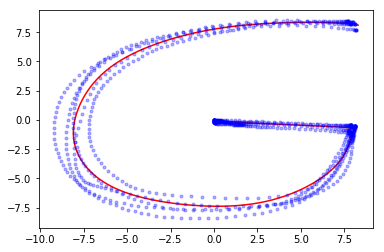

In [25]:
Y_preds = []
for i in range(n_states):
    Y_pred = np.multiply(H[i][:,None], dot(Xr,As[i]))
    Y_preds.append(Y_pred)
    
Y_preds = np.array(Y_preds)
Y_preds = np.sum(Y_preds, axis=0)

plt.plot(Y_preds[:,0], Y_preds[:,1],'-r', alpha=1)
plt.plot(Y[:,0], Y[:,1],'.b', alpha=0.3)

In [26]:
%matplotlib inline

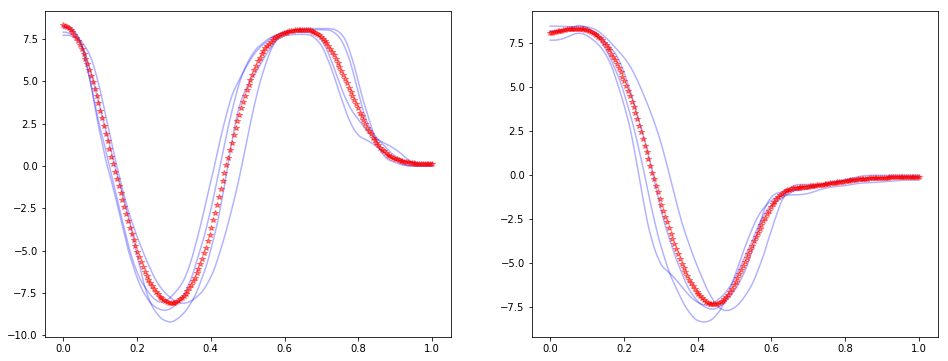

In [27]:
plt.figure(figsize=(16, 6))
for i in range(1,n_samples):
    plt.subplot(1,2,1)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,0],'-b', alpha=0.3)
    plt.subplot(1,2,2)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,1],'-b',alpha=0.3)

plt.subplot(1,2,1)    
plt.plot(t_in, Y_preds[:,0], '*r', alpha=0.5)
plt.subplot(1,2,2)
plt.plot(t_in, Y_preds[:,1], '*r', alpha=0.5)


### GMM with Conditioning 

In [28]:
data_time = np.zeros((data.shape[0], data.shape[1], data.shape[2]+1))
for i in range(n_samples):
    data_time[i] = np.hstack([t_in[:,None], data[i]])
    
#concatenate the whole samples
data_time = np.concatenate(data_time,axis=0)

In [29]:
gmm = GMM(D=3,K=6)

NameError: name 'GMM' is not defined

In [74]:
gmm.fit(data_time)
from IPython.display import clear_output
clear_output()

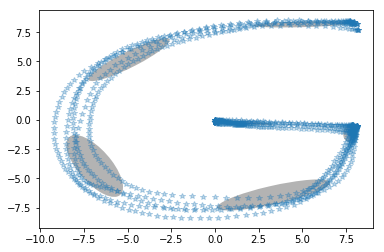

In [75]:
fig,ax = plt.subplots()
plt.plot(data_time[:,1],data_time[:,2],'*',alpha=0.3)
plot_GMM(gmm.means_[:,1:],gmm.covariances_[:,1:,1:],ax)

In [76]:
t = np.linspace(0,1,num=200)
y_pred = []
for i in t:
    y_pred += [gmm.condition(i,dim_in = slice(0,1), dim_out=slice(1,3))[0]]

In [71]:
class GMM():
    def __init__(self, D = 1, K = 2,  reg_factor = 1e-6):
        self.D = D #number of dimensions
        self.K = K #number of mixture components
        self.L = -np.inf #total log likelihood
        self.weights_ = np.ones(K)/K
        self.means_ = np.random.rand(K,D)
        self.covariances_ = np.array([np.eye(D) for i in range(K)])
        self.reg_factor =  reg_factor 

        
    def init_kmeans(self):
        kMM = KMeans(n_clusters=self.K).fit(self.x)
        self.means_ = kMM.cluster_centers_
        for i in range(self.K):
            self.covariances_[i] = np.cov(self.x[kMM.labels_==i].T) + np.eye(self.D)*self.reg_factor
        
    def init_random(self):
        self.means_ = self.x[np.random.choice(len(self.x),size = self.K)]
        for i in range(self.K):
            self.covariances_[i] = np.cov(self.x.T)

    def fit(self,x, max_iter = 10, init_type = 'kmeans', threshold = 1e-4, n_init = 5):
        self.x = x
        self.N = len(self.x) #number of datapoints
        self.Ls = np.zeros((self.N,self.K)) #posterior probability of z
        self.zs = np.zeros((self.N,self.K)) #posterior probability of z

        self.threshold = threshold
        
        best_params = ()
        Lmax = -np.inf
        for it in range(n_init):
            if init_type == 'kmeans':
                self.init_kmeans()
            elif init_type == 'random':
                self.init_random()

            for i in range(max_iter):
                print 'Iteration ' + str(i)
                self.expectation()
                self.maximization()
                print self.L
                if np.abs(self.prev_L-self.L) < self.threshold:
                    break
                    
            if self.L > Lmax:
                Lmax = self.L
                best_params = (self.L, self.weights_.copy(), self.means_.copy(), self.covariances_.copy(), self.zs.copy(), self.Ns.copy())
            
        #return the best result
        self.L = Lmax
        self.weights_ = best_params[1]
        self.means_ = best_params[2]
        self.covariances_ = best_params[3]
        self.zs = best_params[4]
        self.Ns = best_params[5]
        print 'Obtain best result with Log Likelihood: ' + str(self.L)
        
    def expectation(self):
        for k in range(self.K):
            self.Ls[:,k] = self.weights_[k]*mvn.pdf(self.x,mean = self.means_[k], cov=self.covariances_[k])

        self.zs = self.Ls/np.sum(self.Ls,axis=1)[:,None] #normalize

        self.prev_L = self.L
        self.L = np.sum(np.log(np.sum(self.Ls, axis=1)))/self.N
        self.Ns = np.sum(self.zs,axis=0)
             
    def maximization(self):
        for k in range(self.K):
            #update weight
            self.weights_[k] = self.Ns[k]/self.N 

            #update mean
            self.means_[k,:] = np.dot(self.zs[:,k].T, self.x)/self.Ns[k]
            
            #update covariance
            x_reduce_mean = self.x-self.means_[k,:]
            #S_k = dot(x_reduce_mean.T, dot(np.diag(self.zs[:,k]), x_reduce_mean))
            sigma_k = dot(np.multiply(x_reduce_mean.T, self.zs[:,k][None,:]), x_reduce_mean)/self.Ns[k] + np.eye(self.D)*self.reg_factor
            
            self.covariances_[k,:] = sigma_k        
            
    def get_marginal(self,dim,dim_out=None):
        if dim_out is not None:
            means_, covariances_ = (self.means_[:,dim],self.covariances_[:,dim,dim_out])
        else:
            means_, covariances_ = (self.means_[:,dim],self.covariances_[:,dim,dim])
        return means_,covariances_
    
    def condition(self,x_in,dim_in,dim_out,h=None, return_gmm = False):
        mu_in, sigma_in = self.get_marginal(dim_in)
        mu_out, sigma_out = self.get_marginal(dim_out)
        _, sigma_in_out = self.get_marginal(dim=dim_in, dim_out = dim_out)
        
        if h is None:
            h = np.zeros(self.K)
            for k in range(self.K):
                h[k] = self.weights_[k]*mvn(mean=mu_in[k],cov=sigma_in[k]).pdf(x_in)
            h = h/np.sum(h) 
        
        #compute mu and sigma
        mu = []
        sigma = []
        for k in range(self.K):
            mu += [mu_out[k] + np.dot(sigma_in_out[k].T, np.dot(np.linalg.inv(sigma_in[k]), x_in-mu_in[k]))]
            sigma += [sigma_out[k] - np.dot(sigma_in_out[k].T, np.dot(np.linalg.inv(sigma_in[k]), sigma_in_out[k]))]
            
        mu,sigma = (np.asarray(mu),np.asarray(sigma))
        if return_gmm:
            return h,mu,sigma
        else:
            return self.moment_matching(h,mu,sigma)
        
    def moment_matching(self,h,mu,sigma):
        dim = mu.shape[1]
        sigma_out = np.zeros((dim, dim))
        mu_out = np.zeros(dim)
        for k in range(self.K):
            sigma_out += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_out += h[k]*mu[k]
            
        sigma_out -= np.outer(mu_out, mu_out)
        return mu_out,sigma_out
        
    def plot(self):
        fig,ax = plt.subplots()
        plot_GMM(self.means_, self.covariances_, ax)

## Gaussian Mixture Regression (GMR)

#### Declare parameters


In [30]:
n_states = 6

#### Concatenate time to the data 

In [31]:
data_time = np.zeros((data.shape[0], data.shape[1], data.shape[2]+1))
for i in range(n_samples):
    data_time[i] = np.hstack([t_in[:,None], data[i]])
    
#concatenate the whole samples
data_time = np.concatenate(data_time,axis=0)

#### Estimate GMM using the data 

In [32]:
from utils import *
import numpy as np

(-10.090824170988938, 9.069049336475532, -9.22349093629936, 9.367081367719946)

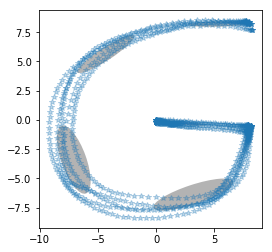

In [33]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = n_states,n_init = 4)
gmm.fit(data_time)

#plot only the spatial components
fig, ax = plt.subplots(figsize = (4,4))
plot_GMM(gmm.means_[:,1:], gmm.covariances_[:,1:,1:],ax)
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,1],data_time[:,2], '*' ,alpha=0.3)
plt.axis('equal')

#### GMR based on the GMM 

In [34]:
gmr = GMR(gmm,n_in = 1, n_out = 2)

#### Predict the data based on the time input

In [35]:
y_preds = []
covs = []
for t in t_in:
    y,cov = gmr.predict(t)
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)

#### Plot data 

(-10.14921159032198, 10.295185142469402, -9.22349093629936, 9.367081367719946)

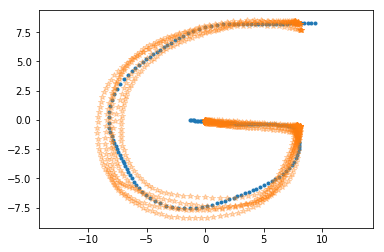

In [36]:
plt.plot(y_preds[:,0], y_preds[:,1], '.')
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,1],data_time[:,2], '*' ,alpha=0.3)
plt.axis('equal')

In [37]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(8,6))

ax = plt.subplot(2,1,1)
plot_GMM(gmm.means_[:,0:2], gmm.covariances_[:,:2,:2], ax)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,0], '-b',alpha = 0.3)

#plot covariances
y_covs1 = covs[:,0,0]
plot_with_covs_1D(t_in, y_preds[:,0],y_covs1, ax)


ax = plt.subplot(2,1,2)
plot_GMM(gmm.means_[:,0::2], gmm.covariances_[:,::2,::2], ax)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,1], '-b',alpha = 0.3)
#plot covariances
y_covs2 = covs[:,1,1]
plot_with_covs_1D(t_in, y_preds[:,1],y_covs2, ax)

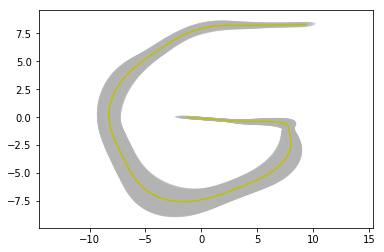

In [38]:
fig,ax = plt.subplots()
for i in range(n_data):
    mu = y_preds[i,:]
    sigma = covs[i]
    plot_gaussian_2D(mu,sigma,ax,alpha=0.6)

plt.axis([-13,10,-20,20])
plt.axis('equal')
plt.plot(y_preds[:,0], y_preds[:,1], 'y')

### GMR with Polynomial inputs 

#### Declare parameters


In [39]:
n_states = 4
deg_poly = 4

In [40]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(deg_poly)
Xt = poly.fit_transform(t_in[:,None])

#### Concatenate time to the data 

In [41]:
data_time = np.zeros((data.shape[0], data.shape[1], data.shape[2]+deg_poly+1))
for i in range(n_samples):
    data_time[i] = np.hstack([Xt, data[i]])
    
#concatenate the whole samples
data_time = np.concatenate(data_time,axis=0)

#### Estimate GMM using the data 

In [42]:
from utils import *
import numpy as np

(-10.092555617351245, 9.105409710083945, -9.227105916634974, 9.442995954767813)

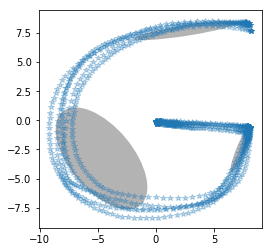

In [43]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = n_states,n_init = 4)
gmm.fit(data_time)

#plot only the spatial components
fig, ax = plt.subplots(figsize = (4,4))
plot_GMM(gmm.means_[:,(deg_poly+1):], gmm.covariances_[:,(deg_poly+1):,(deg_poly+1):],ax)
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,deg_poly+1],data_time[:,deg_poly+2], '*' ,alpha=0.3)
plt.axis('equal')

#### GMR based on the GMM 

In [44]:
gmr = GMR(gmm,n_in = 1+deg_poly, n_out = 2)

#### Predict the data based on the time input

In [45]:
y_preds = []
covs = []
for t in t_in:
    y,cov = gmr.predict(poly.fit_transform(t).flatten())
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)

#### Plot data 

(-10.134682515020778, 9.990074561144144, -9.22349093629936, 9.367081367719946)

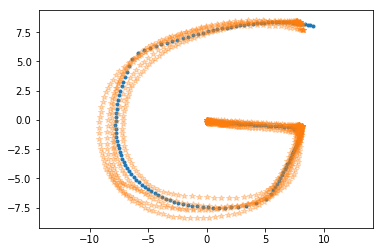

In [46]:
plt.plot(y_preds[:,0], y_preds[:,1], '.')
plt.axis([-13,10,-20,20])
plt.plot(data_time[:,deg_poly+1],data_time[:,deg_poly+2], '*' ,alpha=0.3)
plt.axis('equal')

In [47]:
from matplotlib.patches import Polygon

In [48]:
def plot_with_covs_1D(x, y, cov, ax):
    y_low = y - 2*np.sqrt(cov)
    y_up = y + 2*np.sqrt(cov)
    y_up = y_up[::-1]
    
    x_1 = np.concatenate([x, x[::-1]])
    y_1 = np.concatenate([y_low, y_up])
    xy = np.vstack([x_1,y_1]).T
    poly = Polygon(xy,alpha=0.4)
    ax.add_patch(poly)
    
    plt.plot(x,y,'-r')

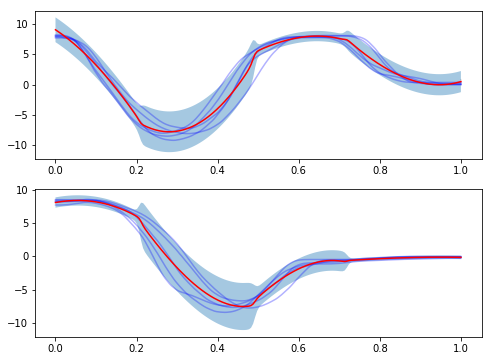

In [49]:
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(2,1,1)
plot_GMM(gmm.means_[:,0:2], gmm.covariances_[:,:2,:2], ax)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,0], '-b',alpha = 0.3)

#plot covariances
y_covs1 = covs[:,0,0]
plot_with_covs_1D(t_in, y_preds[:,0],y_covs1, ax)


ax = plt.subplot(2,1,2)
plot_GMM(gmm.means_[:,0::2], gmm.covariances_[:,::2,::2], ax)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,1], '-b',alpha = 0.3)
#plot covariances
y_covs2 = covs[:,1,1]
plot_with_covs_1D(t_in, y_preds[:,1],y_covs2, ax)

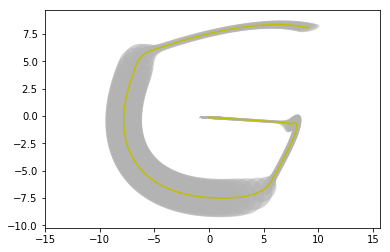

In [50]:
fig,ax = plt.subplots()
for i in range(n_data):
    mu = y_preds[i,:]
    sigma = covs[i]
    plot_gaussian_2D(mu,sigma,ax,alpha=0.6)

plt.axis([-13,10,-20,20])
plt.axis('equal')
plt.plot(y_preds[:,0], y_preds[:,1], 'y')

#### GMM codes 